In [1]:
%matplotlib nbagg
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.dct import colxfm, dct_ii, regroup
from cued_sf2_lab.laplacian_pyramid import bpp, quantise
from scipy.optimize import fsolve
from cued_sf2_lab.rl631_laplacian import plotImg

# 8 The Lapped Bi-orthogonal Transform (LBT)

<div class="alert alert-warning alert-block">
    
This notebook is incomplete!</div>

<p></p>

<!-- sorry for the nasty HTML, markdown is bad for figures -->

<figure style="text-align: center">
<div class="row">
<figure class="col-md-4 col-md-offset-1">
<img src="figures/lbt.png" style="max-height: 350px" />
<figcaption>(a) Lapped Bi-orthogonal Transform</figcaption>
</figure>

<figure class="col-md-5 col-md-offset-1">
<img src="figures/pot.png" style="max-height: 350px" />
<figcaption>(b) Photo Overlap Transform and a DCT</figcaption>
</figure>
</div>
<div class="row">
<figcaption>
<br />

Figure 4: (a) An LBT transforms overlapping sections of `X` to create `Y`. (b) In some cases
this can be interpreted as pre-filtering with a POT, followed by a DCT.</figcaption></div></figure>

One of the difficulties with the DCT is that it processes each block separately and hence
does not take advantage of any correlation between blocks. A possible solution to this is
to use a _Lapped Bi-orthogonal Transform (LBT)_. These transform overlapping blocks in `X`
to generate smaller non-overlapping blocks in `Y`. In the left-hand figure above, 16 values
in `X` are used to generate each set of 8 values in `Y`.

LBTs are quite complicated to derive and analyse: however one of the most popular forms<sup>3</sup>
can also be represented as a pre-filtering operation before performing the DCT described
in the previous section.
In this case the pre-filtering (or post-filtering for the reverse
operation) is sometimes known as a _Photo Overlap Transform or POT_. A POT followed
by a DCT is then equivalent to a particular type of LBT.

The right-hand figure above demonstrates this. The POT is first performed on a section
of data `X`, shifted by `N/2`, so that it runs across the block boundaries of the subsequent
DCT. Ignoring this block shift for a moment, the forward operation for a 2D image `X` is:


$$Y = C ∗ Pf ∗ X ∗ Pf ′ ∗ C′$$

or in reverse

$$ X = Pr′ ∗ C′ ∗ Y ∗ C ∗ Pr $$

<hr />
<small><sup>3</sup>The type-II fast lapped (bi-)orthogonal transform, or LOT-II</small>

## 8.1 Applying the LBT to images

In [2]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0

The pre-filtering `Pf ∗ X ∗ Pf′` (with the correct block shift) is straightforward in Python:

```python
t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
Xp = X.copy()  # copy the non-transformed edges directly from X
Xp[t,:] = colxfm(Xp[t,:], Pf)
Xp[:,t] = colxfm(Xp[:,t].T, Pf).T
```

This is followed by the DCT `C` as before. In the reverse operation, the inverse DCT `C’` is
performed first, followed by Pr’:
```python
Zp = Z.copy()  #copy the non-transformed edges directly from Z
Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
Zp[t,:] = colxfm(Zp[t,:], Pr.T)
```

We have provided a function `pot_ii(N, s)` which will generate a forward (pre-filtering,
`Pf`) and reverse (post-filtering, `Pr`) matrix of size `N` with scaling factor `s`.

In [3]:
from cued_sf2_lab.lbt import pot_ii
from cued_sf2_lab.dct import dct_ii, regroup

Edit your code
for performing DCT analysis so that it can pre-filter `X` with `Pf` before the forward DCT,
then post-filter `Z` with `Pr` after the inverse DCT. Confirm that, without quantisation, this
correctly recreates the original image, i.e. `Zp = X`. Use `Pf, Pr = pot_ii(N)` with the
default scaling value `s`.

In [4]:
# your code here
def forwardLBT(img, N, s):
    # Generate filters
    Pf, Pr = pot_ii(N, s)
    
    # Pre-filtering
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    img_p = img.copy()  # copy the non-transformed edges directly from X
    img_p[t,:] = colxfm(img_p[t,:], Pf)
    img_p[:,t] = colxfm(img_p[:,t].T, Pf).T
    
    # DCT
    Cn = dct_ii(N)
    Yn = colxfm(colxfm(img_p, Cn).T, Cn).T
    
    return Yn
        
    
def reverseLBT(img, N, s):
    # Generate filters
    Pf, Pr = pot_ii(N, s)
    
    # Inverse DCT
    Cn = dct_ii(N)
    Zn = colxfm(colxfm(img.T, Cn.T).T, Cn.T)
    
    # Post-filtering
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    Zp = Zn.copy()  #copy the non-transformed edges directly from Z
    Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
    Zp[t,:] = colxfm(Zp[t,:], Pr.T)
    
    return Zp

In [5]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0
N = 8
s = 1

Y_fLBT = forwardLBT(X, N, s)
Z_rLBT = reverseLBT(Y_fLBT, N, s)
print(np.amax(Z_rLBT-X))
    

6.110667527536862e-13


## 8.2 Quantisation and coding efficiency

The scaling factor `s` determines the degree of bi-orthogonality. If `s = 1` then Pf is the same
as Pr, otherwise `1 < s < 2` weights the relative contributions of `Pf` and `Pr` un-equally.

<div class="alert alert-block alert-danger">

For an 8 × 8 DCT, try implementing an LBT with POT scaling factors varying from $1$
to $2$ ($\sqrt{2}$ is often a good choice). In each case find the quantisation step which makes
the rms error match the directly quantised image. Note the compression ratios and find
the scaling factor which maximises these. Also note the visual features in these images.</div>

In [6]:
def rmsDiff(step, img, N, s):
    rms0 = 4.86116849
    fLBT = forwardLBT(img, N, s)
    fLBTq = quantise(fLBT, step)
    rLBT = reverseLBT(fLBTq, N, s)
    rLBT_rms = np.std(rLBT-img)
    rms_diff = abs(rLBT_rms - rms0)
    
    return rms_diff

In [7]:
def dctbpp(Yr, N):
    # Your code here
    total_bits = np.zeros((N,N))
    Yr_rows, Yr_cols = Yr.shape
    height = int(Yr_rows/N)
    width = int(Yr_cols/N)
    bits = width*height
    for i in range (N):
        for j in range (N):
            Ys = Yr[i*height:(i+1)*height, j*width:(j+1)*width]
            entropy = bpp(Ys)
            total_bits[i][j] = entropy*bits
            
    return np.sum(total_bits)

In [8]:
def lbt_ns(img, N, s, bpp_n = False):
    img_q = quantise(img, 17)
    tbit_imgq = bpp(img_q)*img.shape[0]*img.shape[1]
    
    min_ns = fsolve(rmsDiff, x0 = 17, args = (img, N, s))
    fLBT = forwardLBT(img, N, s)
    fLBTq = quantise(fLBT, min_ns)
    fLBTr = regroup(fLBTq, N)/N
    rLBT = reverseLBT(fLBTq, N, s)
    
    if bpp_n:
        tbit_lbt = dctbpp(fLBTr, 16)
    else:
        tbit_lbt = dctbpp(fLBTr, N)
        
    comp_ratio = tbit_imgq/tbit_lbt
    
    return [tbit_lbt, comp_ratio, min_ns[0], rLBT, fLBTq, fLBTr, fLBT]

In [9]:
def lbt_cr(s, img, N):
    lbt = lbt_ns(img, N, s)
    return -lbt[1]

In [10]:
# Find compression ratio and quantisation step for a range of scaling factors
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0

scalings = np.arange(1,2,0.05)
N = 8

lbts = [lbt_ns(X, N, s) for s in scalings]
lbt_tbit = [lbt[0] for lbt in lbts]
lbt_comp = [lbt[1] for lbt in lbts]
lbt_qstep = [lbt[2] for lbt in lbts]
lbt_r = [lbt[3] for lbt in lbts]

print(np.round(lbt_comp, 3), np.round(lbt_qstep, 3))

C:\Users\Raine Low\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


[3.019 3.057 3.081 3.104 3.116 3.123 3.132 3.134 3.134 3.129 3.122 3.11
 3.086 3.06  3.034 3.01  2.985 2.956 2.924 2.894] [23.37  23.804 24.199 24.551 24.861 25.165 25.438 25.657 25.885 26.034
 26.227 26.354 26.402 26.419 26.465 26.533 26.551 26.557 26.538 26.506]


In [11]:
# from scipy.optimize import minimize, Bounds

# max_comp_s = minimize(lbt_cr, x0 = 1.4, args = (X, N), bounds = Bounds(1.3, 1.5, keep_feasible = True))

# print(max_comp_s)

<div class="alert alert-block alert-danger">
Do not run this unless you have to!!

(1.3, 1.5, 1/10000) takes 7 min
    
 1.335 is optimal scale

In [23]:
# Optimisation to find scaling factor which maximises compression ratio
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0

opt_scalings = np.arange(1, 2, 1/40)
N = 8

opt_lbts = [lbt_ns(X, N, s) for s in opt_scalings]
opt_lbt_tbit = [lbt[0] for lbt in opt_lbts]
opt_lbt_comp = [lbt[1] for lbt in opt_lbts]
opt_lbt_qstep = [lbt[2] for lbt in opt_lbts]

In [24]:
# Find max compression ratio and corresponding scaling factor
opt_max_comp = max(opt_lbt_comp)
index = opt_lbt_comp.index(opt_max_comp)
print(np.round(opt_lbt_comp[index-3:index+4], 6))
print(opt_max_comp, index, opt_scalings[index])

print(lbt_ns(X, N, 1.40)[1])

[3.123398 3.131354 3.132311 3.13628  3.134384 3.134473 3.134256]
3.136279844265081 13 1.3249999999999988
3.134256295979999


<IPython.core.display.Javascript object>


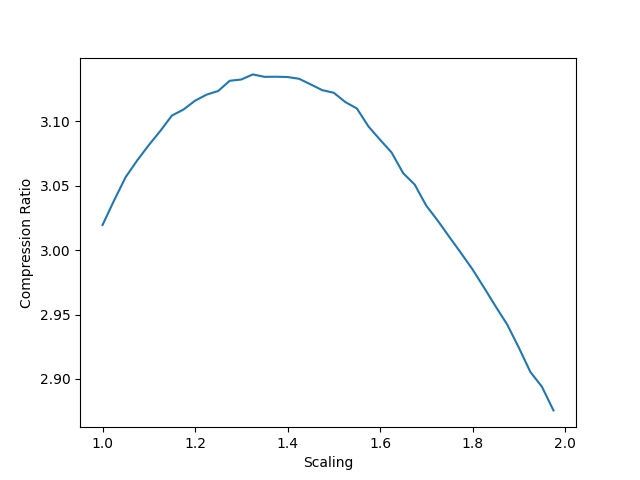

In [25]:
# Store lbt_comp (1.3, 1.5) in lbt_comp_storage
fig, ax = plt.subplots()
plt.plot(opt_scalings, opt_lbt_comp)
plt.show()
plt.xlabel('Scaling')
plt.ylabel('Compression Ratio')
plt.savefig('D:\\Cambridge\\Part IIA\\Projects\\SF2-Image-Processing\\Reports\\Report 2 Figures\\LBT scalings.png')

The POT can often improve both compression and block smoothing, since the pre-filter
acts to reduce correlations between each DCT sub-block, whilst the inverse post-filter
acts to remove the discontinuities between sub-blocks. This is rather different from the
operation of the DCT. Investigate this by looking at the basis functions, as you did with
the DCT:

<IPython.core.display.Javascript object>


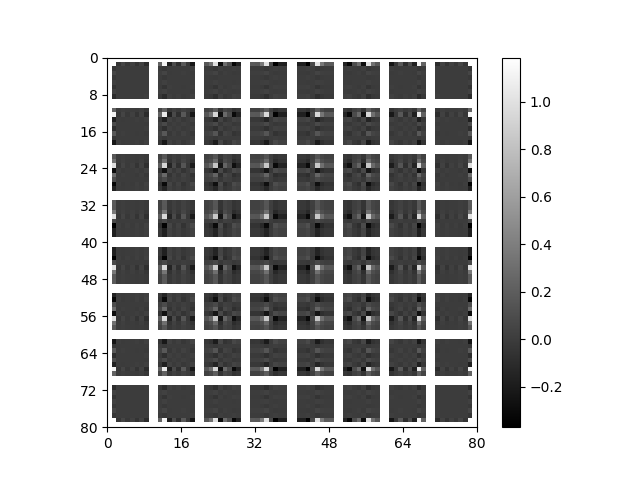

In [16]:
Pf, Pr = pot_ii(8)
bases = np.concatenate([np.full((8,1), np.nan), Pf, np.full((8,1), np.nan)], axis=1)
bases = bases.reshape(-1, 1)
fig, ax = plt.subplots()
im_obj = plot_image(bases @ bases.T, ax=ax)
fig.colorbar(im_obj, ax=ax);

<div class="alert alert-block alert-danger">

Look at both these bases and the pre-filtered image `Xp`, using different scaling factors
`s`, and comment on the visual effect of varying these scaling factors. You may need to
multiply `Xp` by up to 0.5 to display it better.</div>

In [33]:
# Pre-filtering
def prefilter(img, N, s):
    # Generate filters
    Pf, Pr = pot_ii(N, s)
    
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    img_p = img.copy()  # copy the non-transformed edges directly from X
    img_p[t,:] = colxfm(img_p[t,:], Pf)
    img_p[:,t] = colxfm(img_p[:,t].T, Pf).T
    
    return img_p*0.5

In [36]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0
N = 8
scalings = np.arange(1,2,0.05)

Xps = [prefilter(X, N, s) for s in scalings]

<IPython.core.display.Javascript object>


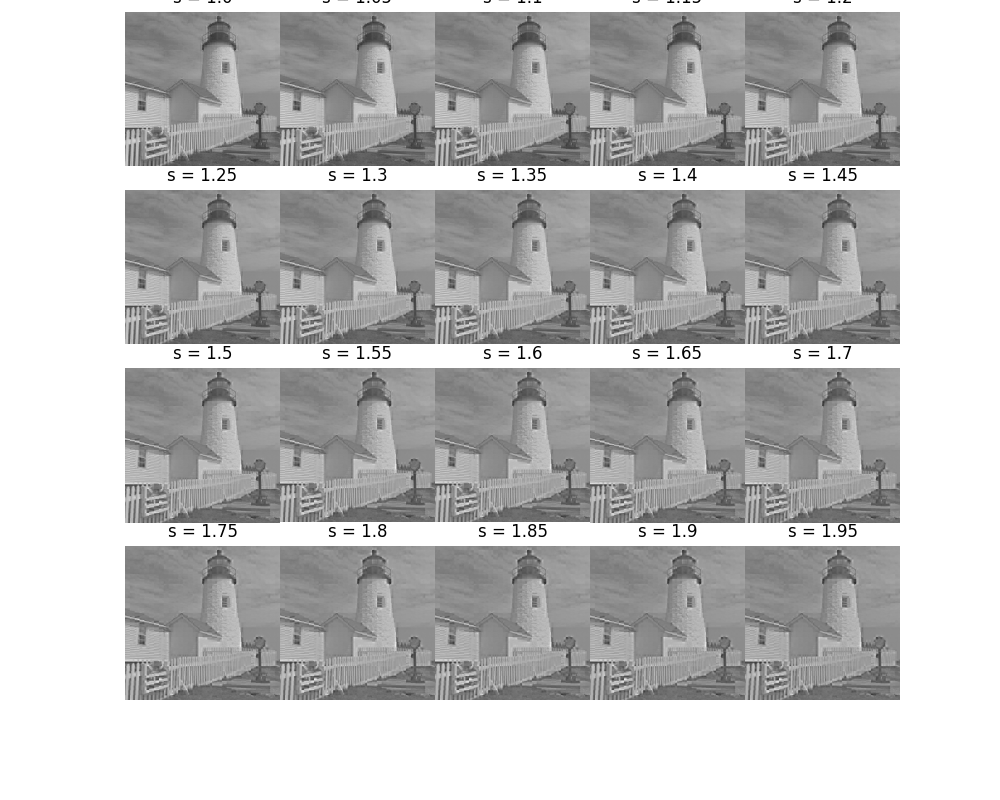

In [37]:
images = Xps
labels = ['s = '+str(np.round(s, 2)) for s in scalings]
plotImg(images, cols = 5, scale = 2, title = '', index = labels, cmap  = 'gray', save = True, name = 'Report 2 Figures\\Xp_srange.png')

<IPython.core.display.Javascript object>


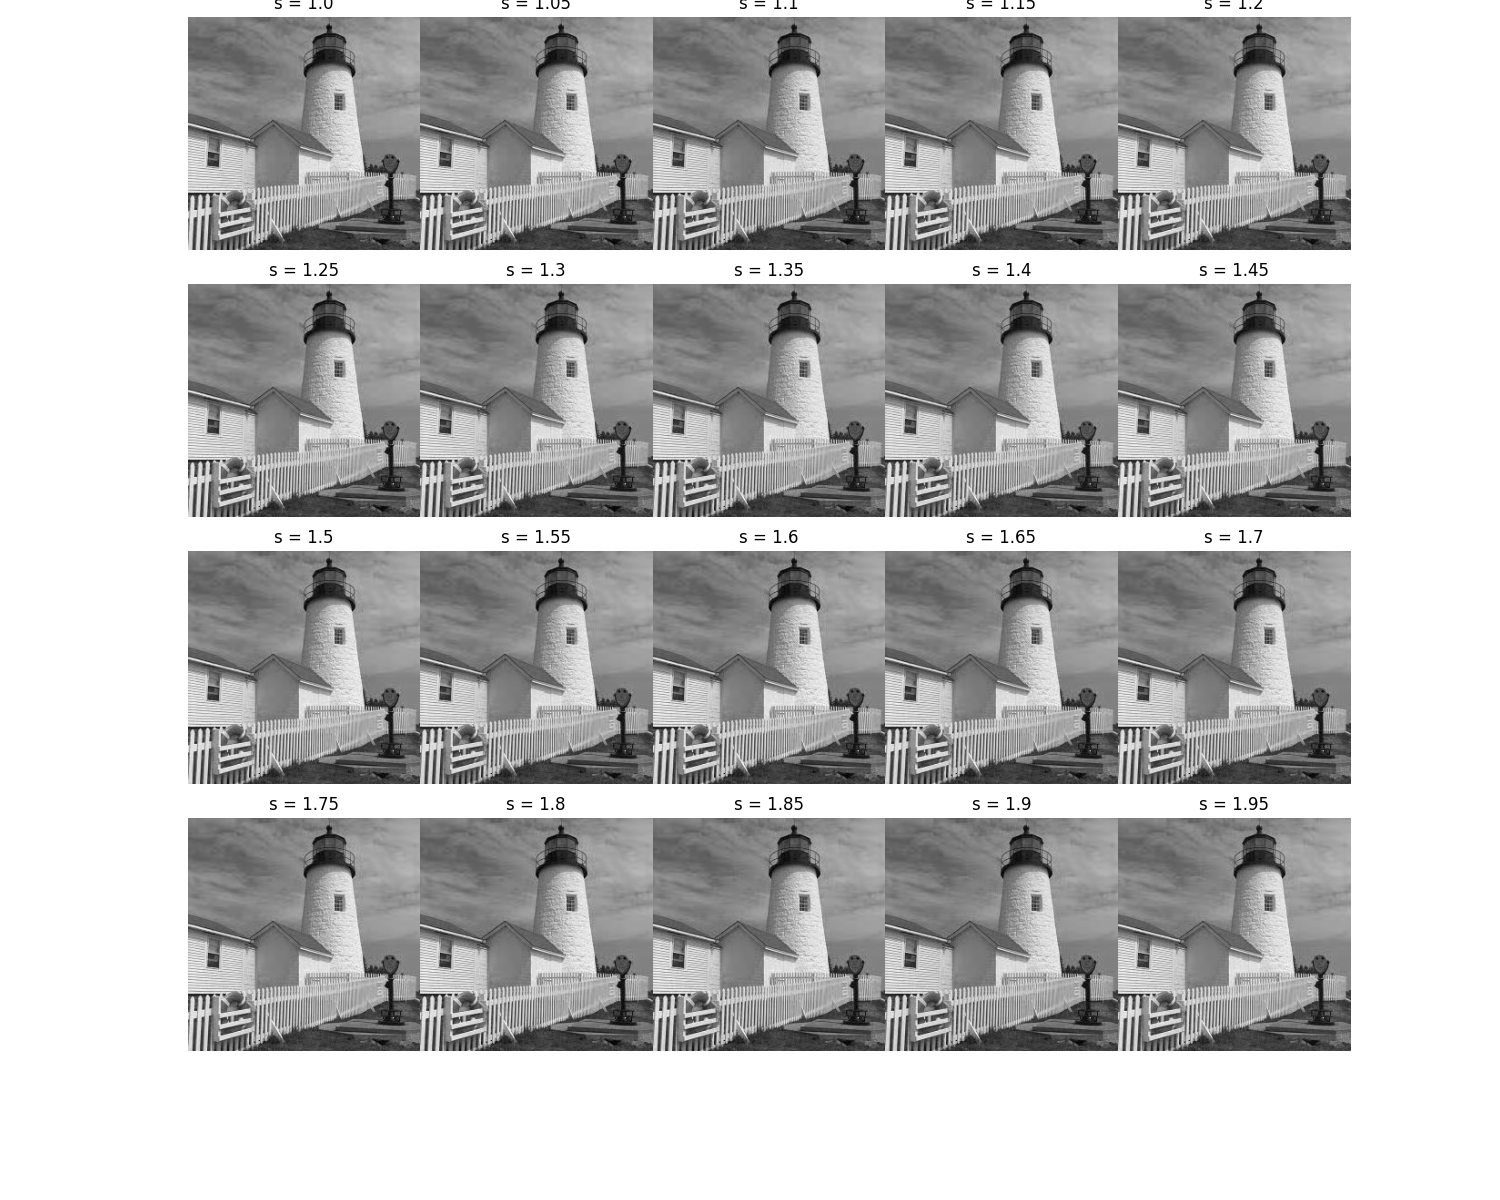

In [38]:
# Displaying recovered quantised images for different s
images = lbt_r
labels = ['s = '+str(np.round(s, 2)) for s in scalings]
plotImg(images, cols = 5, scale = 3, title = '', index = labels, cmap  = 'gray', save = True, name = 'Report 2 Figures\\LBT_srange.png')

With this type of POT / DCT combination it is common to use smaller DCT block sizes
but to code several blocks together. Hence a more accurate estimate of the number of bits
is found by always using 16 × 16 blocks, i.e. regroup `Yq` with the correct size `N` to give
`Yr`, but then always use `dctbpp(Yr, 16)`.

<div class="alert alert-block alert-danger">

Investigate the relative visual and compression performance of LBTs with 4 × 4, 8 × 8
and 16 × 16 blocks, using the scaling factor you have previously selected. As before, be
careful to match the rms error with a directly quantised image.</div>

In [18]:
# your code here
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0
Xq = quantise(X, 17)

s = 1.335
Ns = [4, 8, 16]

nlbts = [lbt_ns(X, N, s, bpp_n = True) for N in Ns]
nlbt_tbit = [lbt[0] for lbt in nlbts]
nlbt_comp = [lbt[1] for lbt in nlbts]
nlbt_qstep = [lbt[2] for lbt in nlbts]
nlbt_r = [lbt[3] for lbt in nlbts]

[3.5617075201573978, 3.430151215706438, 2.9502582304171123] [28.16691463645375, 25.622095015081626, 22.81944893582024]


<IPython.core.display.Javascript object>


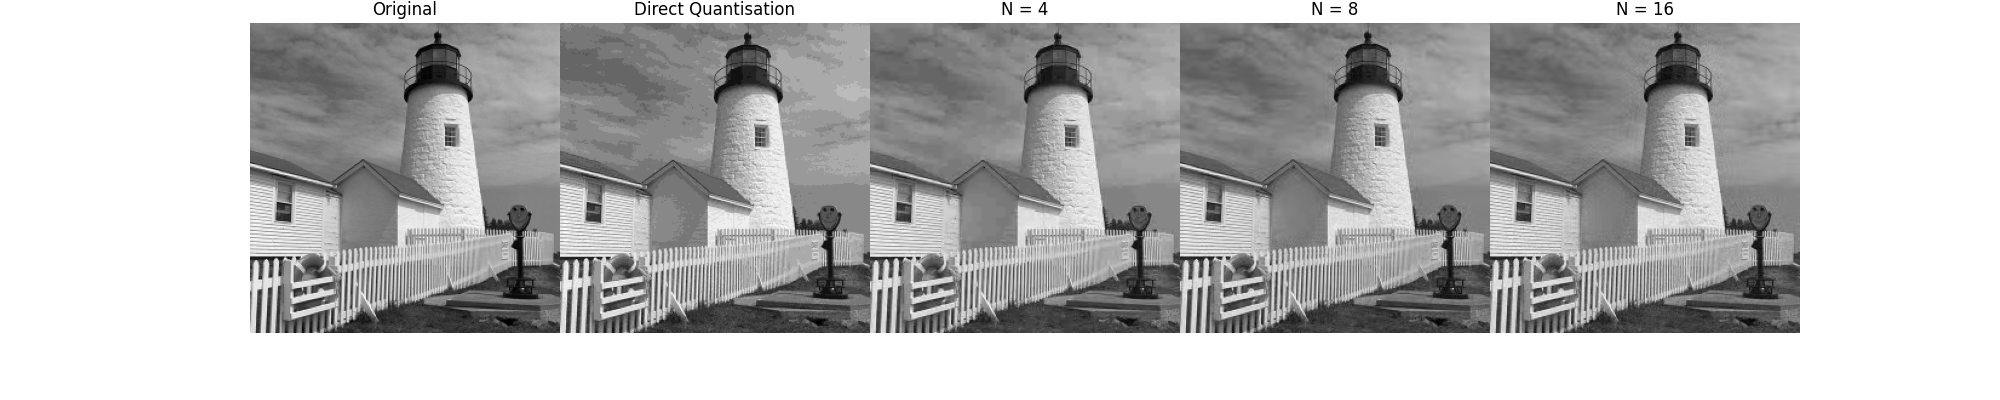

In [19]:
print(nlbt_comp, nlbt_qstep)
images = [X, Xq] + nlbt_r
labels = ['Original', 'Direct Quantisation', 'N = 4', 'N = 8', 'N = 16']
plotImg(images, cols = 5, title = '', index = labels, cmap  = 'gray', save = True, name = 'Report 2 Figures\\LBT_4_8_16.png')